In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)



In [5]:

# Load datasets
# Load datasets
training_data_path = '/Users/sca/Desktop/POLIMI/AN2DL/Challenge2/training_dataset/training_data.npy'
valid_periods_path = '/Users/sca/Desktop/POLIMI/AN2DL/Challenge2/training_dataset/valid_periods.npy'
categories_path = '/Users/sca/Desktop/POLIMI/AN2DL/Challenge2/training_dataset/categories.npy'
training_data = np.load(training_data_path)
valid_periods = np.load(valid_periods_path)
categories = np.load(categories_path)



In [6]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(training_data, categories, test_size=0.2, random_state=seed)




In [7]:
# Standardize the Dataset
scaler = StandardScaler()

# Fit on training data and transform
x_train_flat = x_train.reshape((-1, x_train.shape[-1]))  # Flatten the time series data for standardization
x_train_scaled = scaler.fit_transform(x_train_flat)  # Fit and transform scaler
x_train_scaled = x_train_scaled.reshape((-1, 2776, 1))  # Reshape back to the original shape with one feature



In [8]:
# Transform test data
x_test_flat = x_test.reshape((-1, x_test.shape[-1]))
x_test_scaled = scaler.transform(x_test_flat)  # Only transform the test set
x_test_scaled = x_test_scaled.reshape((-1, 2776, 1))  # Reshape back to the original shape with one feature

# Now x_train_scaled and x_test_scaled can be used for training and evaluation


In [9]:

# One-hot encode the labels
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))



In [10]:
# Reshape the standardized data back to the original shape with one feature per time step
x_train_scaled = x_train_flat.reshape((-1, 2776, 1))
x_test_scaled = x_test_flat.reshape((-1, 2776, 1))

In [11]:
# Define the CNN model architecture
def build_1DCNN_classifier(input_shape, num_classes):
    input_layer = Input(shape=input_shape, name='Input')
    
    # Define the CNN layers with dropout for regularization
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Dropout(0.3)(cnn)
    
    cnn = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Dropout(0.3)(cnn)
    
    cnn = GlobalAveragePooling1D()(cnn)
    
    # Dense layers for classification
    cnn = Dense(128, activation='relu')(cnn)
    cnn = Dropout(0.3)(cnn)
    output_layer = Dense(num_classes, activation='softmax')(cnn)
    
    # Compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.MeanSquaredError()])
    return model



In [12]:
# Initialize the model
num_classes = y_train_encoded.shape[1]
model = build_1DCNN_classifier(input_shape=(2776, 1), num_classes=num_classes)



In [17]:
# Prepare callbacks for training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)
]



In [18]:

# Train the model
history = model.fit(
    x_train_scaled, 
    y_train_encoded,
    validation_data=(x_test_scaled, y_test_encoded),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
600/600 [==============================] - 93s 154ms/step - loss: 1.5031 - accuracy: 0.3178 - mean_squared_error: 0.1261 - val_loss: 1.4718 - val_accuracy: 0.3458 - val_mean_squared_error: 0.1238 - lr: 0.0010
Epoch 2/100
600/600 [==============================] - 93s 155ms/step - loss: 1.4738 - accuracy: 0.3390 - mean_squared_error: 0.1239 - val_loss: 1.4434 - val_accuracy: 0.3619 - val_mean_squared_error: 0.1217 - lr: 0.0010
Epoch 3/100
600/600 [==============================] - 92s 154ms/step - loss: 1.4551 - accuracy: 0.3453 - mean_squared_error: 0.1226 - val_loss: 1.4285 - val_accuracy: 0.3576 - val_mean_squared_error: 0.1208 - lr: 0.0010
Epoch 4/100
600/600 [==============================] - 95s 159ms/step - loss: 1.4440 - accuracy: 0.3522 - mean_squared_error: 0.1219 - val_loss: 1.4213 - val_accuracy: 0.3695 - val_mean_squared_error: 0.1202 - lr: 0.0010
Epoch 5/100
600/600 [==============================] - 92s 153ms/step - loss: 1.4338 - accuracy: 0.3579 - mean_squar

In [19]:
# Evaluate the model
evaluation_results = model.evaluate(x_test_scaled, y_test_encoded, verbose=0)

# Depending on how many metrics you've compiled the model with, adjust the number of variables here
test_loss, test_accuracy, test_mse = evaluation_results

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Mean Squared Error: {test_mse}')


Test Loss: 1.2574888467788696
Test Accuracy: 0.47572916746139526
Test Mean Squared Error: 0.10735182464122772


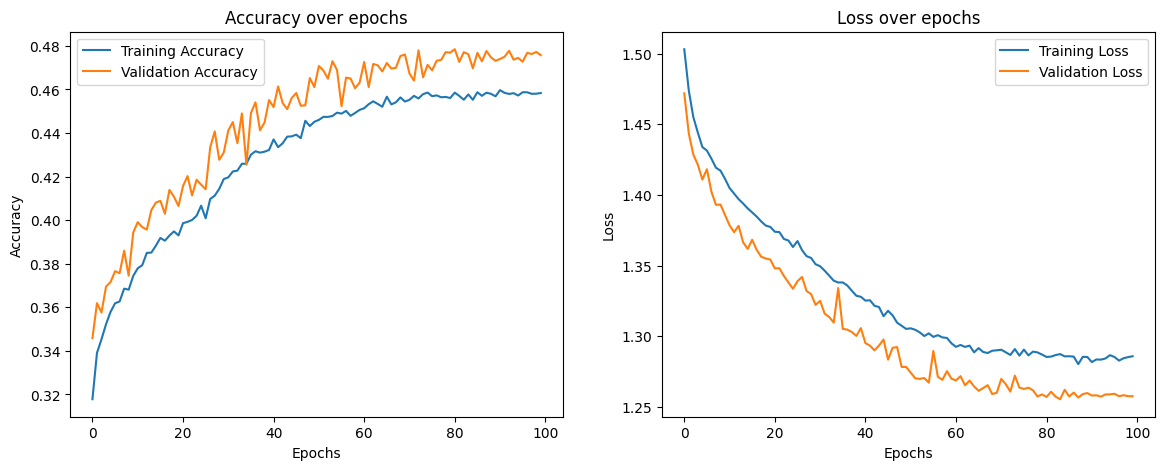

In [20]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(14, 5))

# Access the history attribute of the History object to get the training history
history_dict = history.history

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [22]:
model.save('SubmissionModel4.keras')